In [1]:
import os
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import numpy as np
from tqdm import tqdm


# image cut

In [2]:
folder = r"E:\data\Good"
data_path = []
for filename in os.listdir(folder):
    data_path.append(os.path.join(folder, filename))

In [8]:
# sin_ticket_list_error = [
#     [10, 10, 850, 850],
#     [780, 30, 1620, 870],
#     [1560, 40, 2400, 880],
#     [10, 780, 850, 1620],
#     [1550, 800, 2390, 1640]
# ]
# sinner = 0
# weare = 770

# image = Image.open(data_path[49])

# fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# for i, (left, upper, right, lower) in enumerate(sin_ticket_list_error):
#     cropped_region = (left, upper, right, lower)
#     cropped_image = image.crop(cropped_region)
#     axs[i].imshow(cropped_image, cmap='gray')
#     axs[i].axis('off')

# plt.show()

In [9]:
# topLeft center topRight bottomLeft bottomRight
sin_ticket_list = [
    [40, 100, 880, 940],
    [810, 100, 1650, 940],
    [1580, 100, 2420, 940],
    [30, 880, 870, 1720],
    [1590, 880, 2430, 1720]
]
# image size (840, 840)
sin_ticket_list_error = [
    [10, 10, 850, 850],
    [780, 30, 1620, 870],
    [1560, 40, 2400, 880],
    [10, 780, 850, 1620],
    [1550, 800, 2390, 1640]
]
sinner = 0
weare = 770

In [10]:
data_path[49]

'E:\\data\\Good\\2_5.bmp'

In [ ]:
output_path = r"E:\data\Goodcut"
os.makedirs(output_path, exist_ok=True)

for image_path in tqdm(data_path):
    image = Image.open(image_path)

    for number in range(1, 6):
        if image == r"E:\\data\\Good\\2_5.bmp":
            left, upper, right, lower = sin_ticket_list_error[number - 1]
        else:
            left, upper, right, lower = sin_ticket_list[number - 1]
        output_filename = os.path.join(output_path, f"{os.path.basename(image_path)[:4].replace(".", "")}_{number}.jpg")
        cropped_region = (left, upper, right, lower)
        cropped_image = image.crop(cropped_region)
        cropped_image.save(output_filename, 'JPEG')


# 증강

In [ ]:
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

class VAECustomDataset(Dataset):
    def __init__(self, file_paths, transform=None, gauss_sigma=0.05):
        self.file_paths = file_paths
        self.transform = transform
        self.gauss_sigma = gauss_sigma

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])
        if self.transform:
            original_image = self.transform(image)
            noisy_image = gauss_noise(original_image, self.gauss_sigma)
            images = rotate_images(image)
            transformed_images = [self.transform(img) for img in images]
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]
            return original_image, noisy_image, transformed_images, noisy_images
        else:
            return image

In [ ]:
img_size = 480

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor(), 
])


In [ ]:
folder = r"E:\data\Goodcut"
data_path = []
for filename in os.listdir(folder):
    data_path.append(os.path.join(folder, filename))

In [ ]:
custom_dataset = VAECustomDataset(data_path, transform=transform)

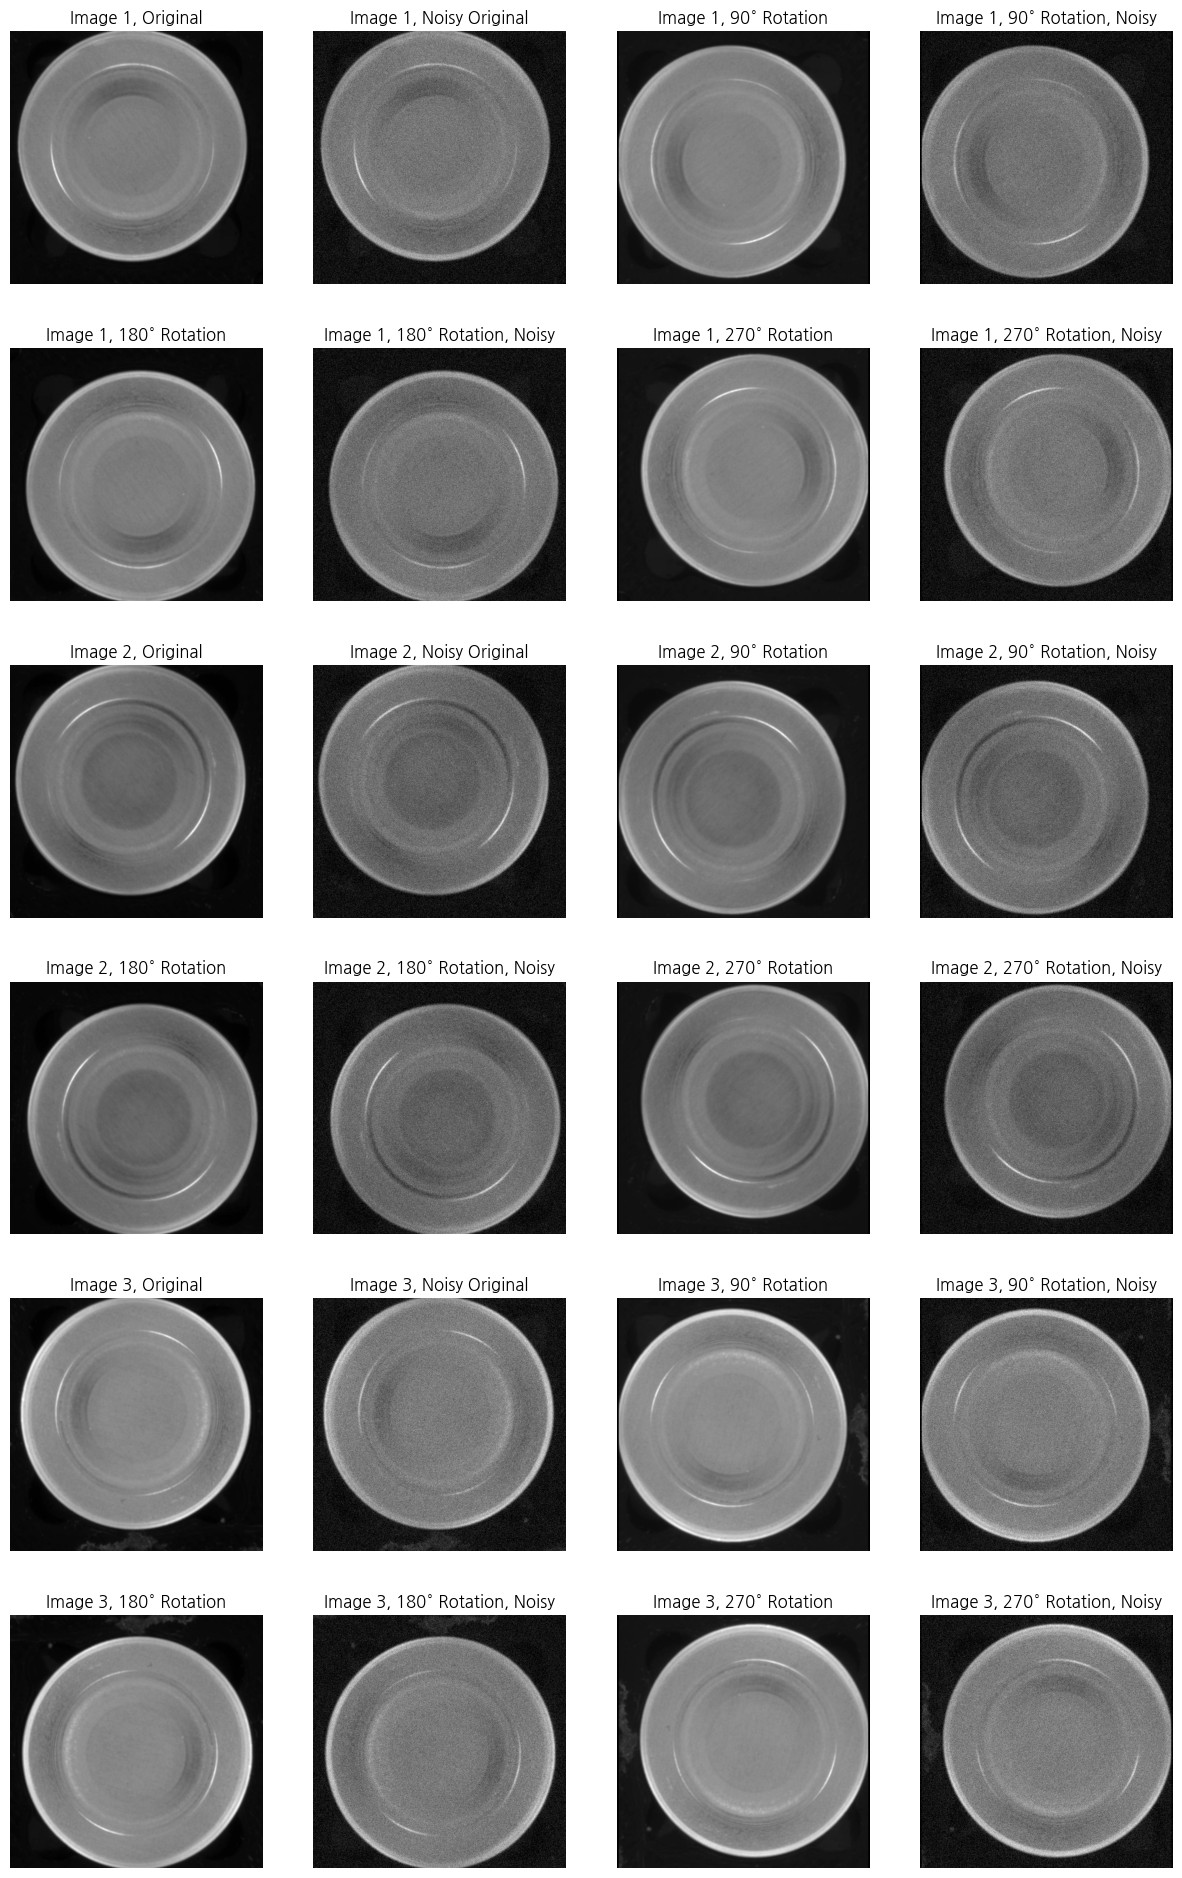

In [ ]:
num_rows = 3 * 2
plt.figure(figsize=(15, num_rows * 4))
for i in range(3):
    original_image, noisy_image, transformed_images, noisy_images = custom_dataset[i]

    # Original Image
    plt.subplot(num_rows, 4, i * 8 + 1)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Original')
    plt.axis('off')

    # Noisy Original Image
    plt.subplot(num_rows, 4, i * 8 + 2)
    plt.imshow(noisy_image.squeeze(), cmap='gray')
    plt.title(f'Image {i+1}, Noisy Original')
    plt.axis('off')

    # Rotated Images
    for j in range(3):
        plt.subplot(num_rows, 4, i * 8 + 3 + j * 2)
        plt.imshow(transformed_images[j + 1].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation')
        plt.axis('off')

        plt.subplot(num_rows, 4, i * 8 + 4 + j * 2)
        plt.imshow(noisy_images[j + 1].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}, {90 * (j + 1)}° Rotation, Noisy')
        plt.axis('off')

plt.show()